# Black Friday: predicting purchase amounts

### Classical Data Analysis Final Project on Regression and Classification
#### Jordi Hurtado, Annalaura Ianiro, Benjamin Wein

In [33]:
#Starting with the basic imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

The Black Friday dataset is a sample of the transactions made in a retail store. The store wants to know better the customer purchase behaviour against different products. Specifically, here the problem is a regression problem, where we are trying to predict the dependent variable (the amount of purchase) with the help of the information contained in the other variables. The dataset comes from a competition hosted by Analytics Vidhya.

In [3]:
bf=pd.read_csv('BlackFriday.csv')

The variables in the dataset are the following:

In [4]:
bf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


User_ID: Id of the user

Product_ID: Id of the purchased product

Gender: Boolean variable

Age: Age classes of the customers

Occupation Id: Id of the occupation of each customer

City_Category: Category of the city the customer is in 

Stay_In_Current_City_Years: time in classes of the cutomer's permanence in the current city

Marital_Status: Binary Variable

Product_Category_1: categorical variable

Product_Category_2

Product_Category_3

Purchase: Purchase amount in dollars

Unfortunately, we do not have much information about the meaning of the variables. We do not know what the different product categories stands for, nor the occupation IDs. Same goes for the city category. For this reason, any deeper interpretation of these variables is almost impossible to do. It complicates the feature engineering work, since we cannot rely too much on common sense logic to try to make initial assosiations among variables. 

## EDA

Our dataset, except for the target variable, is made of categorical variables. We need to convert the data type of the variables which are supposed to be categorical but are not read as such.

First, however, we will look at the product categories features: Product_Category_1, Product_Category_2 and Product_Category_3. As it can be see above, from the command bf.info(), these last two varaiables are the only containing NaN. Let's deep dive a little into them:

In [5]:
bf['Product_Category_1'].value_counts(normalize=True)

5     0.276411
1     0.257364
8     0.208588
11    0.044570
2     0.043713
6     0.037509
3     0.036923
4     0.021517
16    0.018038
15    0.011539
13    0.010119
10    0.009361
12    0.007208
7     0.006823
18    0.005720
14    0.002790
17    0.001055
9     0.000752
Name: Product_Category_1, dtype: float64

In [6]:
bf['Product_Category_2'].value_counts(normalize=True)

8.0     0.170155
14.0    0.146140
2.0     0.130821
16.0    0.114957
15.0    0.100696
5.0     0.069818
4.0     0.068067
6.0     0.043852
11.0    0.037629
17.0    0.035430
13.0    0.027980
9.0     0.015087
12.0    0.014623
10.0    0.008071
3.0     0.007650
18.0    0.007367
7.0     0.001660
Name: Product_Category_2, dtype: float64

In [7]:
bf['Product_Category_3'].value_counts(normalize=True)

16.0    0.195693
15.0    0.168075
14.0    0.110307
17.0    0.100129
5.0     0.099709
8.0     0.075384
9.0     0.069480
12.0    0.055357
13.0    0.032780
6.0     0.029328
18.0    0.027776
4.0     0.011201
11.0    0.010793
10.0    0.010336
3.0     0.003652
Name: Product_Category_3, dtype: float64

In [8]:
print('Percentage of NaN values in Product_Category_2: %s' 
      %round((bf['Product_Category_2'].isna().sum())/len(bf['Product_Category_2']),2))
print('Percentage of NaN values in Product_Category_3: %s' 
      %round((bf['Product_Category_3'].isna().sum())/len(bf['Product_Category_3']),2))

Percentage of NaN values in Product_Category_2: 0.31
Percentage of NaN values in Product_Category_3: 0.69


As it can be seen above, the percentage of NaN values in the two features is considerable, especially for Product_Category_3. 

Since we do not know anything about the meaning of this categories or how they are related to each other, it is not feasible to try and infer the possible values behind this NaN. It can also be that these NaN are not missing values in the proper sense, but simply the product does not have a second or third category. If this is the case, we could consider NaN as a category in itself. However, we cannot be sure about it. 

Another thing we don't know is whether across category 1, 2 and 3, the same number means the same thing. Let's assume that category 5 is electronics. So, a product that has a 5 in Product_Category_1 belongs to electronics. What about another product which has a 5 in Product_Category_2. Does that 5 still represents electronic or the categories in Product_Category_2 are subcategories of Product_Category_1 and therefore that 5 means something else? The same reasoning applies to NaN values in categories 2 and 3: does it mean that there are no subcategories for that product or simply that the product can only be classified in one categories instead of 2 or 3?

Given this uncertainty and the high number of NaN values we deemed best to drop Product_Category_2 and Product_Category_3 from our analysis. Afterall, even without those, we still have a considerable number of features to analyse.

Now, we convert the data types

In [9]:
bf['Occupation'] = bf['Occupation'].astype(object)
bf['Marital_Status'] = bf['Marital_Status'].astype(object)
bf['Product_Category_1'] = bf['Product_Category_1'].astype(object)
bf['User_ID'] = bf['User_ID'].astype(object)
bf['Product_ID'] = bf['Product_ID'].astype(object)

### Purchase distribution

Below, we can see the distribution of the only continuous variable in our dataset. 

In [44]:
round(bf['Purchase'].describe(),2)

count    537577.00
mean       9333.86
std        4981.02
min         185.00
25%        5866.00
50%        8062.00
75%       12073.00
max       23961.00
Name: Purchase, dtype: float64

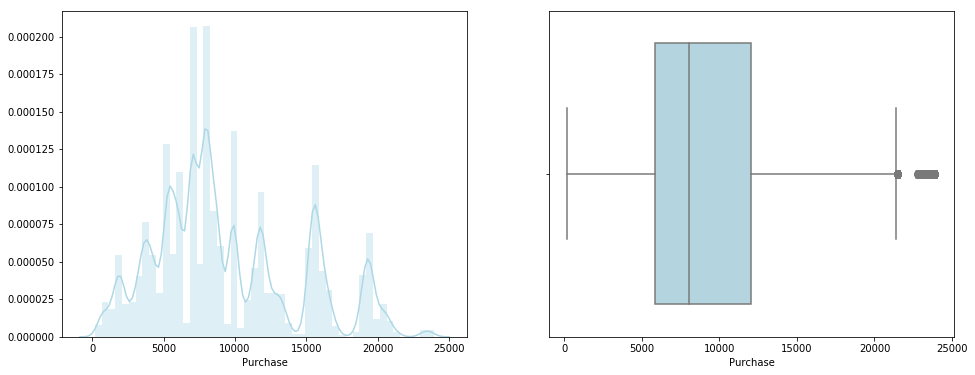

In [172]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
sns.distplot(bf['Purchase'], ax=ax[0], color='lightblue');
sns.boxplot(bf['Purchase'], ax=ax[1], color='lightblue');

We can see that the distribution is not normal, and neither the mean nor the median would be representative of it. There seem to be some outliers, but given the nature of the variable and the shape of the distribution we decided not to consider them as such and leave them be.

### Purchase vs the rest

Since all of our variables are categorical, we cannot use the correlation heatmap to see tehir relationship with the target variable. Therefore, we have to use barplots.

In [12]:
#Preparing the dataframes for the visualization. 
#We group by each category and display the sum of purchases and its mean value 
#(although the latter is not that meaningful) 

bf_gender1=bf.groupby('Gender', as_index=False)['Purchase'].sum()
bf_gender2=bf.groupby('Gender', as_index=False)['Purchase'].mean()

bf_age1=bf.groupby('Age', as_index=False)['Purchase'].sum()
bf_age2=bf.groupby('Age', as_index=False)['Purchase'].mean()

bf_occupation1=bf.groupby('Occupation', as_index=False)['Purchase'].sum()
bf_occupation2=bf.groupby('Occupation', as_index=False)['Purchase'].mean()


bf_city1=bf.groupby('City_Category', as_index=False)['Purchase'].sum()
bf_city2=bf.groupby('City_Category', as_index=False)['Purchase'].mean()

bf_years1=bf.groupby('Stay_In_Current_City_Years', as_index=False)['Purchase'].sum()
bf_years2=bf.groupby('Stay_In_Current_City_Years', as_index=False)['Purchase'].mean()

bf_marital1=bf.groupby('Marital_Status', as_index=False)['Purchase'].sum()
bf_marital2=bf.groupby('Marital_Status', as_index=False)['Purchase'].mean()

bf_pc1_1=bf.groupby('Product_Category_1', as_index=False)['Purchase'].sum()
bf_pc1_2=bf.groupby('Product_Category_1', as_index=False)['Purchase'].mean()

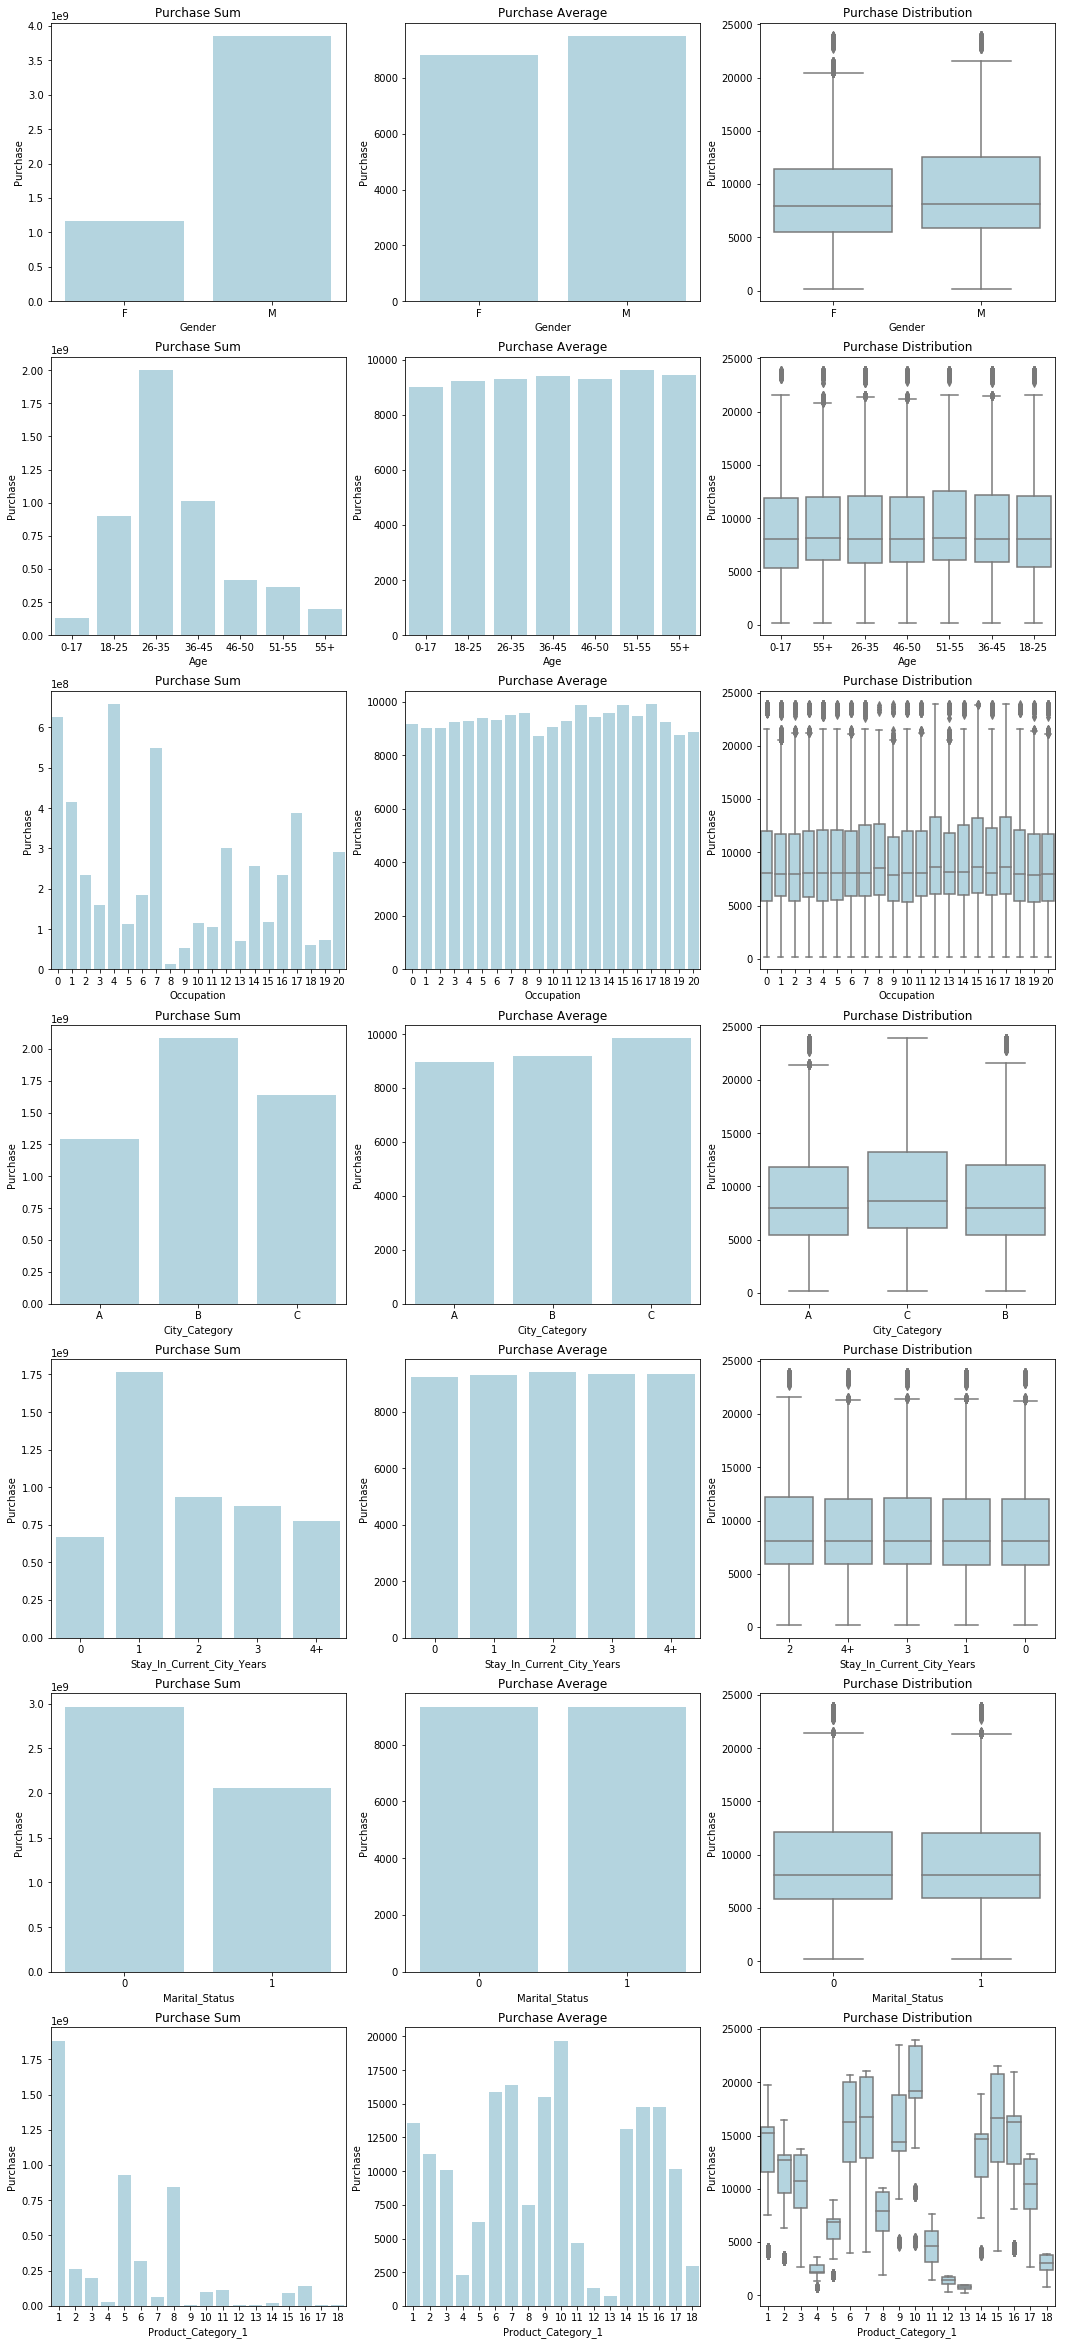

In [100]:
#Visualization Code
fig, ax = plt.subplots(nrows=7, ncols=3, figsize=(18, 42))


sns.barplot(x='Gender', y='Purchase', data=bf_gender1, ax=ax[0,0], color='lightblue').set_title('Purchase Sum');
sns.barplot(x='Gender', y='Purchase', data=bf_gender2, ax=ax[0,1], color='lightblue').set_title('Purchase Average');
sns.boxplot(x='Gender', y='Purchase', data=bf, ax=ax[0,2], color='lightblue').set_title('Purchase Distribution');

sns.barplot(x='Age', y='Purchase', data=bf_age1, ax=ax[1,0], color='lightblue').set_title('Purchase Sum');
sns.barplot(x='Age', y='Purchase', data=bf_age2, ax=ax[1,1], color='lightblue').set_title('Purchase Average');
sns.boxplot(x='Age', y='Purchase', data=bf, ax=ax[1,2], color='lightblue').set_title('Purchase Distribution');

sns.barplot(x='Occupation', y='Purchase', data=bf_occupation1, ax=ax[2,0], color='lightblue').set_title('Purchase Sum');
sns.barplot(x='Occupation', y='Purchase', data=bf_occupation2, ax=ax[2,1], color='lightblue').set_title('Purchase Average');
sns.boxplot(x='Occupation', y='Purchase', data=bf, ax=ax[2,2], color='lightblue').set_title('Purchase Distribution');

sns.barplot(x='City_Category', y='Purchase', data=bf_city1, ax=ax[3,0], color='lightblue').set_title('Purchase Sum');
sns.barplot(x='City_Category', y='Purchase', data=bf_city2, ax=ax[3,1], color='lightblue').set_title('Purchase Average');
sns.boxplot(x='City_Category', y='Purchase', data=bf, ax=ax[3,2], color='lightblue').set_title('Purchase Distribution');

sns.barplot(x='Stay_In_Current_City_Years', y='Purchase', data=bf_years1, ax=ax[4,0], color='lightblue').set_title('Purchase Sum');
sns.barplot(x='Stay_In_Current_City_Years', y='Purchase', data=bf_years2, ax=ax[4,1], color='lightblue').set_title('Purchase Average');
sns.boxplot(x='Stay_In_Current_City_Years', y='Purchase', data=bf, ax=ax[4,2], color='lightblue').set_title('Purchase Distribution');

sns.barplot(x='Marital_Status', y='Purchase', data=bf_marital1, ax=ax[5,0], color='lightblue').set_title('Purchase Sum');
sns.barplot(x='Marital_Status', y='Purchase', data=bf_marital2, ax=ax[5,1], color='lightblue').set_title('Purchase Average');
sns.boxplot(x='Marital_Status', y='Purchase', data=bf, ax=ax[5,2], color='lightblue').set_title('Purchase Distribution');

sns.barplot(x='Product_Category_1', y='Purchase', data=bf_pc1_1, ax=ax[6,0], color='lightblue').set_title('Purchase Sum');
sns.barplot(x='Product_Category_1', y='Purchase', data=bf_pc1_2, ax=ax[6,1], color='lightblue').set_title('Purchase Average');
sns.boxplot(x='Product_Category_1', y='Purchase', data=bf, ax=ax[6,2], color='lightblue').set_title('Purchase Distribution');

Product_Category_1 seems to be the features along which the target variables changes the most, in terms of sum, average and distribution. This makes a lot of sense, because the price of a product and thus the purchase amount usually depends on the type of product you buy. 

As far as the other variables are concerned we can try to combine them and see whether their effect on purchases changes.

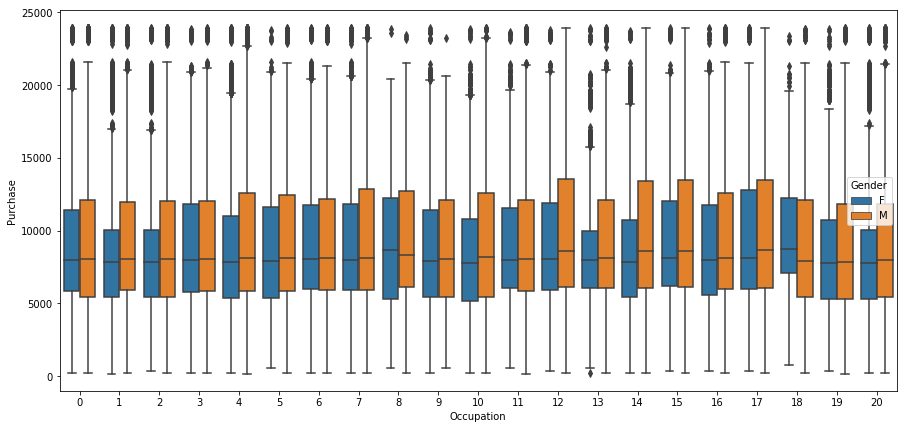

In [14]:
fig = plt.subplots(figsize=(15, 7))
sns.boxplot(x='Occupation', y='Purchase', data=bf, hue='Gender');

In the graph above we can see the distribution of purchases along the different occupation categories by gender. Overall, it seems that men tend to spend more than women across each occupation. Furthermore, there seem to be more differences in the purchase distribution across occupations if we take also the gender into account. Before proceeding further, it could be worth to deep dive a little into the gender variable to answer questions such as "Are there more men than women in the datasets?" or "Do men spend more because there is more of them or because they buy more expensive type of products?"

#### Gender

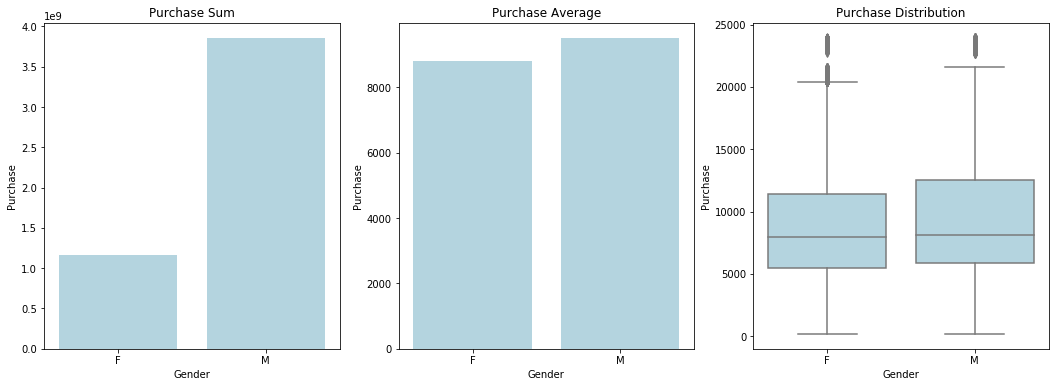

In [101]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

sns.barplot(x='Gender', y='Purchase', data=bf_gender1, ax=ax[0], color='lightblue').set_title('Purchase Sum');
sns.barplot(x='Gender', y='Purchase', data=bf_gender2, ax=ax[1], color='lightblue').set_title('Purchase Average');
sns.boxplot(x='Gender', y='Purchase', data=bf, ax=ax[2], color='lightblue').set_title('Purchase Distribution');

Purchases seem to be higher for men tha female. Why is that?

In order to find how many men and women are in the sample, I can use the User_Id field. Indeed, one user may purchase more than one product, appearing in the dataset more than once.

In [16]:
bf['User_ID'].nunique()

5891

There are 5891 distinct customers in the sample, dicided in the two gender as following:

In [17]:
bf.groupby('Gender')['User_ID'].nunique()

Gender
F    1666
M    4225
Name: User_ID, dtype: int64

We can see that there are more than double men than women. But how many purchases in total do they each do? Maybe women purchase more item than men.

In [18]:
bf['Gender'].value_counts()

M    405380
F    132197
Name: Gender, dtype: int64

In [19]:
bf['Gender'].value_counts(normalize=True)

M    0.754087
F    0.245913
Name: Gender, dtype: float64

75% of the purchased items was bought by men. It seems that the the difference in purchases across gender might be due to numerosity. The final check is wheter men buy more expensive product.

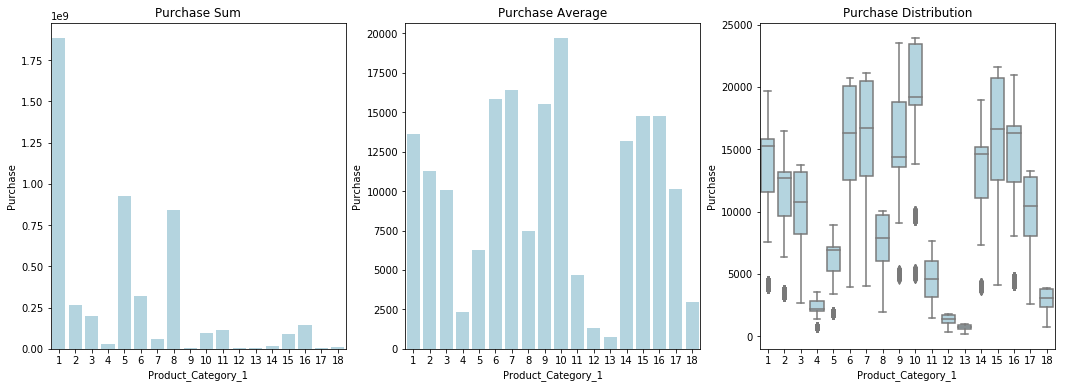

In [102]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 6))

sns.barplot(x='Product_Category_1', y='Purchase', data=bf_pc1_1, ax=ax[0], color='lightblue').set_title('Purchase Sum');
sns.barplot(x='Product_Category_1', y='Purchase', data=bf_pc1_2, ax=ax[1], color='lightblue').set_title('Purchase Average');
sns.boxplot(x='Product_Category_1', y='Purchase', data=bf, ax=ax[2], color='lightblue').set_title('Purchase Distribution');

Looking at the purchase distribution across product categories is clear that there categories more expensive than others. 

In [21]:
bf.groupby('Product_Category_1')['Gender'].value_counts(normalize=True).unstack()

Gender,F,M
Product_Category_1,,
1,0.176368,0.823632
2,0.237159,0.762841
3,0.295934,0.704066
4,0.308810,0.691190
5,0.277263,0.722737
6,0.221930,0.778070
7,0.252999,0.747001
8,0.293823,0.706177
9,0.173267,0.826733


Looking at the table, we can see that men bought more products than women in each category. Men are more, buy more and more expensive than women in our sample. 

## Other interactions

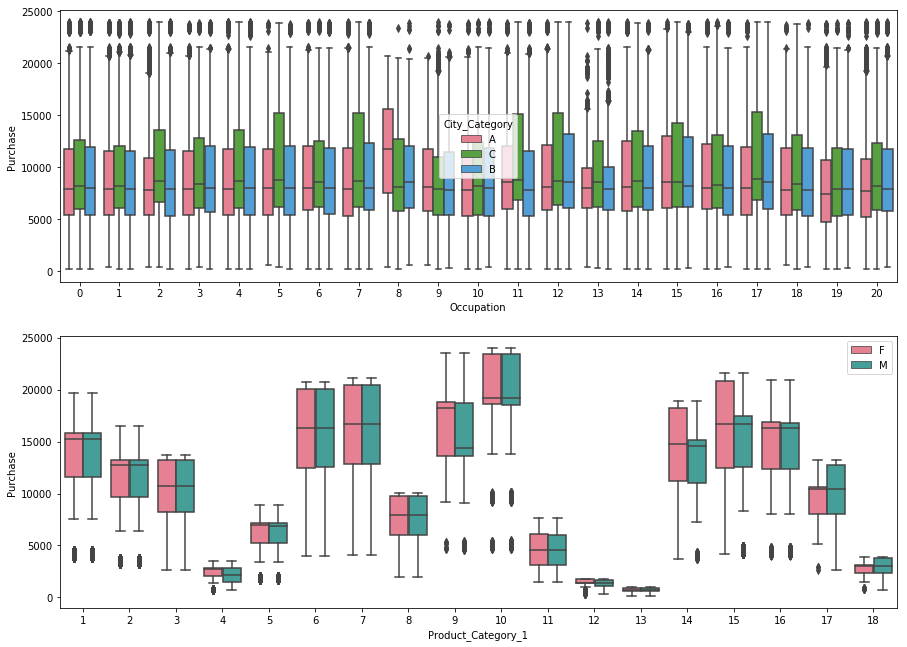

In [110]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 11))

sns.boxplot(x='Occupation', y='Purchase', data=bf, hue='City_Category', palette='husl', ax=ax[0]);
sns.boxplot(x='Product_Category_1', y='Purchase', data=bf, hue='Gender', palette='husl', ax=ax[1]);
plt.legend(loc='best');

# Regressions

## Data pre-processing

As explained before, we decided to drop Product_Category_2 and Product_Category_3 from the analysis. We also decided to drop User_ID and Product_ID. Using these variables in the fitting part would be highly informative; however, it would not be useful for the prediction. Product_ID would imply that when I am predicting I already know the item bought, which is not credible. If I knew, I would not need to predict the purchase amount. User_ID would restrict the prediction to the id in the dataset. If a new customer came by, without an id because is new, then I could not predict the purchase amount, even if I knew the value of all the other variables for them. 

In [22]:
bf_reg = bf.drop(columns=['User_ID', 'Product_ID', 'Product_Category_2', 'Product_Category_3'])

In [23]:
X = bf_reg.drop(columns='Purchase')
y = bf_reg['Purchase']

In [24]:
X = pd.get_dummies(X, drop_first='True')

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

## Baseline regression

We run a simple OLS regression, which will represent our benchmark to beat. When comparing different models is important to do cross-validation. The scores of a model depend on the train - test split. Cross-validation allows to perform several split and train/test the model on them, so that we can obtain more robust scores.
The models comparison will be done according to the root mean squared error (RMSE). 

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
from sklearn.model_selection import KFold

In [30]:
ols_bench = LinearRegression()

In [31]:
def kfold_cv(model, X_train, y_train, cv=50):
    """
    Creates the interactions variable between two features and performs a regression for each pair
    
    Parameters
    ----------
    
    model: 
        initilized object of the model to train
    X_train: pandas.core.frame.DataFrame
        train dataset containing the variables to interact
    y_train: pandas.core.series.Series
        train dataset containing the target variable
    cv: int
        number of cross-validation splits to perform. Deafult value is 50.
        
    Returns
    ----------
    
    cv_df: pandas.core.frame.DataFrame
        dataframe with the results of the regression
    """
    
    
    l_r_2 = []
    l_mse_test=[]
    l_mse_train=[]
    l_mae_test=[]
    l_mae_train=[]
    l_rmse_test=[]
    l_rmse_train=[]
    kf=KFold(cv, random_state=11)
    for train, test in kf.split(X_train, y_train): #this is the loop for iterating across the kfold splits
        model.fit(X_train.iloc[train], y_train.iloc[train])
        r_2 = model.score(X_train.iloc[train], y_train.iloc[train]) #computig the Rsquared of the regression
        pred = model.predict(X_train.iloc[test]) 
        pred_tr = model.predict(X_train.iloc[train])
        mse_test = mean_squared_error(y_train.iloc[test],pred) #computing the mse on the test
        mse_train = mean_squared_error(y_train.iloc[train],pred_tr) #computing the mse on the train
        mae_test = mean_absolute_error(y_train.iloc[test],pred) #computing the mae on the test
        mae_train = mean_absolute_error(y_train.iloc[train],pred_tr) #computing the mae on the train
        rmse_test = np.sqrt(mean_squared_error(y_train.iloc[test],pred)) #computing the rmse on the test
        rmse_train = np.sqrt(mean_squared_error(y_train.iloc[train],pred_tr)) #computing the rmse on the train
        l_r_2.append(r_2)
        l_mse_test.append(mse_test)
        l_mse_train.append(mse_train)
        l_mae_test.append(mae_test)
        l_mae_train.append(mae_train)
        l_rmse_test.append(rmse_test)
        l_rmse_train.append(rmse_train)

    entries = [l_r_2, l_mse_test,l_mse_train, l_mae_test, l_mae_train, l_rmse_test, l_rmse_train]
    cv_df = pd.DataFrame(entries).T 
    cv_df.columns = ['R_2_score','mse_test','mse_train', 'mae_test', 'mae_train', 'rmse_test', 'rmse_train']
    return cv_df

In [34]:
ols_bench_cv = kfold_cv(model=ols_bench, X_train=X_train, y_train=y_train)

In [36]:
print('R2 score: ', round(ols_bench_cv['R_2_score'].mean(),2))
print('RMSE on train sample: ', round(ols_bench_cv['rmse_train'].mean(),2))
print('RMSE on validation sample: ', round(ols_bench_cv['rmse_test'].mean(),2))
print('MSE on train sample: ', round(ols_bench_cv['mse_train'].mean(),2))
print('MSE on validation sample: ', round(ols_bench_cv['mse_test'].mean(),2))
print('MAE on train sample: ', round(ols_bench_cv['mae_train'].mean(),2))
print('MAE on validation sample: ', round(ols_bench_cv['mae_test'].mean(),2))

R2 score:  0.63
RMSE on train sample:  3027.61
RMSE on validation sample:  3027.93
MSE on train sample:  9166435.27
MSE on validation sample:  9169196.04
MAE on train sample:  2299.46
MAE on validation sample:  2299.79


As it can be seen from the above metrics, the prediction errors are high, around 3000 dollars. However, given that the average and median purchase levels are, respectively, 9333.86 and 8062.00, it does not seem that unreasonable, also considering the range of the purchase distribution. In the graphs below, we can see the distributions of the errors on the train and validation set.

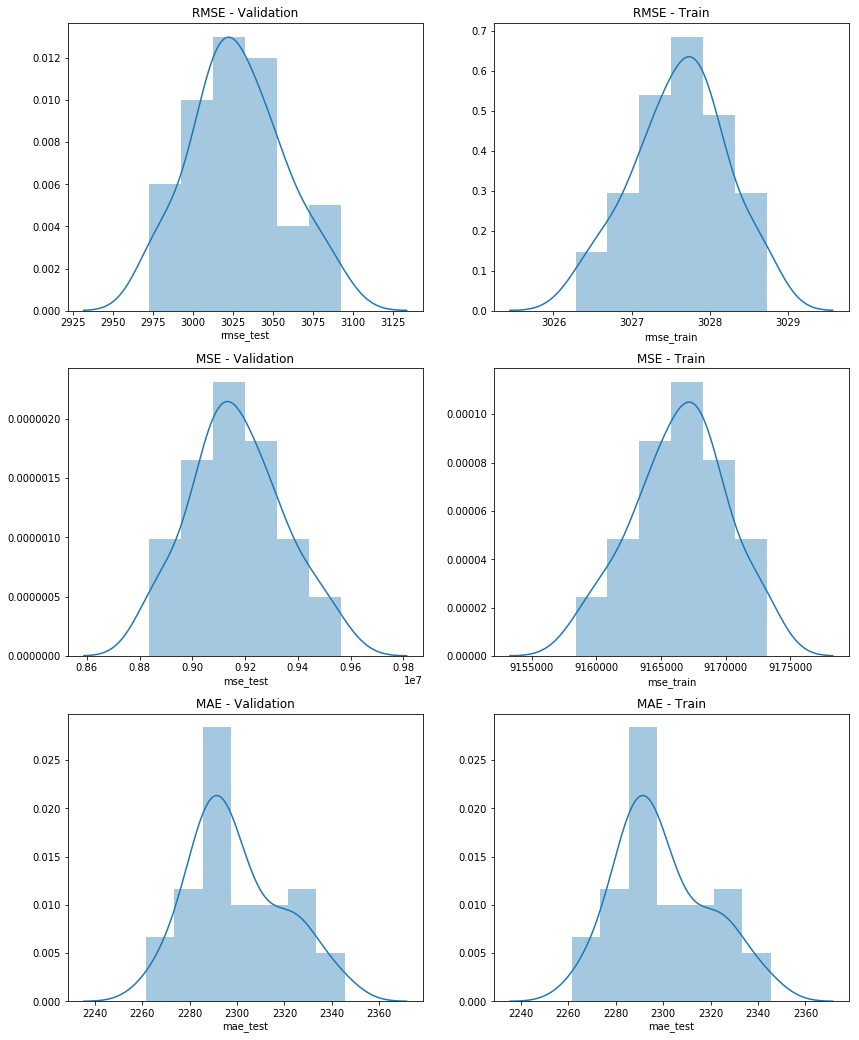

In [54]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14,18))
sns.distplot(ols_bench_cv['rmse_test'], ax = ax[0,0]).set_title('RMSE - Validation');
sns.distplot(ols_bench_cv['rmse_train'], ax = ax[0,1]).set_title('RMSE - Train');
sns.distplot(ols_bench_cv['mse_test'], ax= ax[1,0]).set_title('MSE - Validation');
sns.distplot(ols_bench_cv['mse_train'], ax = ax[1,1]).set_title('MSE - Train');
sns.distplot(ols_bench_cv['mae_test'], ax = ax[2,0]).set_title('MAE - Validation');
sns.distplot(ols_bench_cv['mae_test'], ax= ax[2,1]).set_title('MAE - Train');

## Interactions

A way to try to improve the results of our baseline regression is interacting the different dummies among each other and add these interactions to the feature matrix. The interaction variables allow to capture the combined effect of two or more variable on our target. 
The function below interacts dummies in pairs and run the function kfold_cv on them.

In [41]:
def regression_with_interactions(feature_1, feature_2, X_train, y_train, model, cv):
    """
    Creates the interactions variable between two features and performs a regression for each pair
    
    Parameters
    ----------
    
    feature_1: string
        name of the variable we want interact
    feature_2: string
        name of the variable we want interact
    X_train: pandas.core.frame.DataFrame
        train dataset containing the variables to interact
    y_train: pandas.core.series.Series
        train dataset containing the target variable
    cv: int
        number of cross-validation splits to perform
        
    Returns
    ----------
    
    cv_df_int: pandas.core.frame.DataFrame
        dataframe with the results of the regression
    """
    
    X_train_copy=X_train #creating a copy so the function does not overwrite the original dataframe.
    data_subset_1 = X_train_copy[X_train_copy.columns[pd.Series(X_train_copy.columns).str.startswith(feature_1)]]
    data_subset_2 = X_train_copy[X_train_copy.columns[pd.Series(X_train_copy.columns).str.startswith(feature_2)]]
    for feature_A in data_subset_1.columns:
        for feature_B in data_subset_2.columns:
            interaction = X_train_copy[feature_A] * X_train_copy[feature_B]
            X_train_copy = pd.concat([X_train_copy, interaction], axis=1)
    #Using kfold_cv function to the dataframe with the interactions.        
    cv_df_int = kfold_cv(model=model, X_train=X_train_copy, y_train=y_train, cv=cv)
    return cv_df_int

We apply the function above and try to see whether interacting different pairs of values improves the regression results over the benchmark.

In [43]:
gen_occ = regression_with_interactions('Gender', 'Occupation', X_train, y_train, ols_bench, cv=50)

In [56]:
age_occ = regression_with_interactions('Age', 'Occupation', X_train, y_train, ols_bench, cv=50)

In [45]:
prod_occ = regression_with_interactions('Product_Category_1', 'Occupation', X_train, y_train, ols_bench, cv=50)

In [46]:
gen_prod = regression_with_interactions('Product_Category_1', 'Gender', X_train, y_train, ols_bench, cv=50)

In [47]:
age_prod = regression_with_interactions('Age', 'Product_Category_1', X_train, y_train, ols_bench, cv=50)

In [49]:
mar_prod = regression_with_interactions('Marital_Status', 'Product_Category_1', X_train, y_train, ols_bench, cv=50)

In [51]:
city_prod = regression_with_interactions('City_Category', 'Product_Category_1', X_train, y_train, ols_bench, cv=50)

In [52]:
year_prod = regression_with_interactions('Stay_In_Current_City_Years', 'Product_Category_1', X_train, y_train, ols_bench, cv=50)

In [129]:
pd.DataFrame(data={'Benchmark':[round(ols_bench_cv['rmse_test'].mean(),2), round(ols_bench_cv['rmse_train'].mean(),2)],
                   'Gender - Occupation': [round(gen_occ['rmse_test'].mean(),2), round(gen_occ['rmse_train'].mean(),2)], 
                   'Age - Occupation': [round(age_occ['rmse_test'].mean(),2), round(age_occ['rmse_train'].mean(),2)], 
                   'Product - Occupation': [round(prod_occ['rmse_test'].mean(),2), round(prod_occ['rmse_train'].mean(),2)],
                   'Gender - Product': [round(gen_prod['rmse_test'].mean(),2), round(gen_prod['rmse_train'].mean(),2)],
                   'Age - Product': [round(age_prod['rmse_test'].mean(),2), round(age_prod['rmse_train'].mean(),2)],
                   'Marital - Product': [round(mar_prod['rmse_test'].mean(),2), round(mar_prod['rmse_train'].mean(),2)],
                   'City - Product': [round(city_prod['rmse_test'].mean(),2), round(city_prod['rmse_train'].mean(),2)],
                   'Year - Product': [round(year_prod['rmse_test'].mean(),2), round(year_prod['rmse_train'].mean(),2)]}, 
             index=['RMSE validation', 'RMSE train'])

,Benchmark,Gender - Occupation,Age - Occupation,Product - Occupation,Gender - Product,Age - Product,Marital - Product,City - Product,Year - Product
RMSE validation,3027.93,3027.15,3022.14,3026.93,3027.75,3026.74,3027.89,3024.28,3027.87
RMSE train,3027.61,3026.67,3021.01,3023.10,3027.26,3025.40,3027.42,3023.62,3026.89


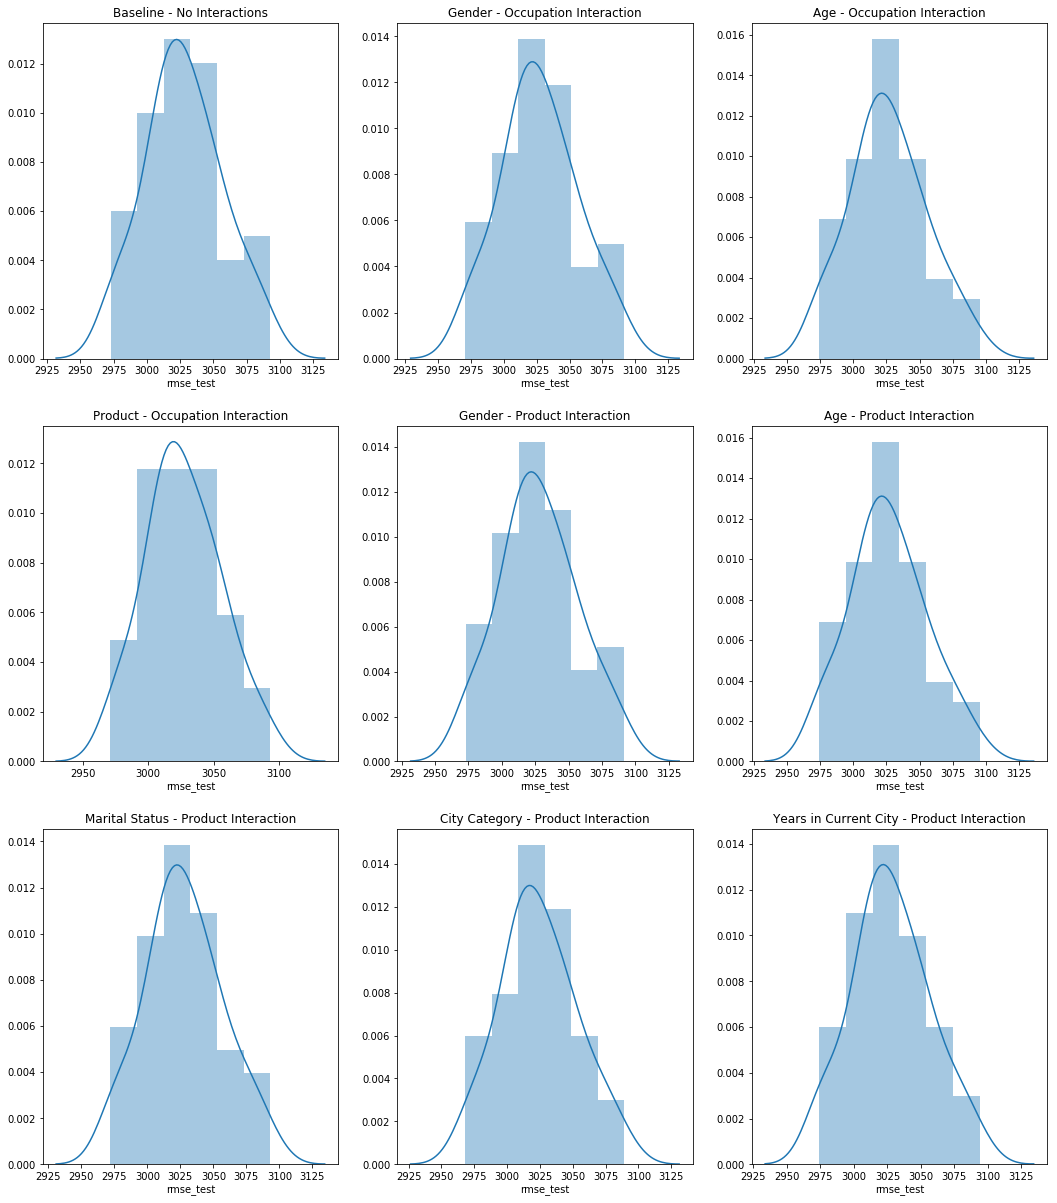

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,21))
sns.distplot(ols_bench_cv['rmse_test'], ax = ax[0,0]).set_title('Baseline - No Interactions');
sns.distplot(gen_occ['rmse_test'], ax = ax[0,1]).set_title('Gender - Occupation Interaction');
sns.distplot(age_occ['rmse_test'], ax= ax[0,2]).set_title('Age - Occupation Interaction');
sns.distplot(prod_occ['rmse_test'], ax = ax[1,0]).set_title('Product - Occupation Interaction');
sns.distplot(gen_prod['rmse_test'], ax = ax[1,1]).set_title('Gender - Product Interaction');
sns.distplot(age_prod['rmse_test'], ax= ax[1,2]).set_title('Age - Product Interaction');
sns.distplot(mar_prod['rmse_test'], ax= ax[2,0]).set_title('Marital Status - Product Interaction');
sns.distplot(city_prod['rmse_test'], ax= ax[2,1]).set_title('City Category - Product Interaction');
sns.distplot(year_prod['rmse_test'], ax= ax[2,2]).set_title('Years in Current City - Product Interaction');


As it can be seen from the graps and the average scores, there is hardly any improvements over the baseline regression. Interacting variables in pairs does not seem to be the road for better prediction results.

## Regularization

Although there does not seem to be problems of overfitting, our feature matrix has a lot of variables and it could be that not all of them actually provide useful information for the regression. In the next part, we will try to run Ridge and Lasso regressions and see whether constraining the baseline model might bring better results.

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV

In [63]:
ridge = RidgeCV(alphas=(0.01, 0.1, 1, 10), cv=50) #no random state available for RidgeCV
lasso = LassoCV(alphas=[0.01, 0.1, 1, 10], cv=50, random_state=10)

In [64]:
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.01,  0.1 ,  1.  , 10.  ]), cv=50, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [65]:
ridge.score(X_train, y_train)

0.6303812687643102

In [66]:
ridge.alpha_

1.0

The cross validation picked alpha = 1 as the best value for Ridge model; however, the resulting score is not better than the benchmark one. 

In [69]:
lasso.fit(X_train, y_train)

LassoCV(alphas=[0.01, 0.1, 1, 10], copy_X=True, cv=50, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
    normalize=False, positive=False, precompute='auto', random_state=10,
    selection='cyclic', tol=0.0001, verbose=False)

In [73]:
lasso.score(X_train, y_train)

0.6303812763200134

In [74]:
lasso.alpha_

0.01

The cross validation picked alpha = 0.01 as the best value for Lasso model; however, the resulting score is not better than the benchmark one. 

We know have a look at the coefficients of Ridge and Lasso compared with our benchmark model and see how strong was the regularization.

In [82]:
bench = LinearRegression()
bench.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [86]:
pd.DataFrame(data={'Benchmark':bench.coef_,'Ridge': ridge.coef_, 'Lasso': lasso.coef_}, index=X_train.columns)

,Benchmark,Ridge,Lasso
Gender_M,-46.491437,-46.415595,-46.408269
Age_18-25,-176.086286,-176.099397,-177.034550
Age_26-35,-77.922824,-77.949931,-78.987016
Age_36-45,60.527812,60.455177,59.418426
Age_46-50,73.514200,73.387553,72.222790
Age_51-55,314.496030,314.354020,313.189305
Age_55+,215.047099,214.857775,213.735596
Occupation_1,-41.326877,-41.356880,-41.792840
Occupation_2,37.683711,37.637690,36.847090
Occupation_3,238.500276,238.438344,237.598400


The coefficient all looks very similar. To truly see a difference we should set higher alpha. However, we would loose in terms of prediction score. 

### Comperison benchmark vs Ridge and Lasso

In [93]:
from sklearn.linear_model import Ridge, Lasso

In [96]:
ridge2 = Ridge(alpha = 1)
ridge3 = Ridge(alpha = 10)
lasso2 = Lasso(alpha = 0.01)
lasso3 = Lasso(alpha = 1)

We run our cross-validation function on ridge and lasso to get the RMSE for the model comparison. We use the optimal alphas coming from the previous cross validation, as well as higher alphas to see the effect of a much restricted model.

In [97]:
ridge_cv1 = kfold_cv(model=ridge2, X_train=X_train, y_train=y_train)

In [98]:
ridge_cv2 = kfold_cv(model=ridge3, X_train=X_train, y_train=y_train)

In [99]:
lasso_cv1 = kfold_cv(model=lasso2, X_train=X_train, y_train=y_train)

In [103]:
lasso_cv2 = kfold_cv(model=lasso3, X_train=X_train, y_train=y_train)

In [104]:
pd.DataFrame(data={'Benchmark':[round(ols_bench_cv['rmse_test'].mean(),2), round(ols_bench_cv['rmse_train'].mean(),2)],
                   'Ridge - 1': [round(ridge_cv1['rmse_test'].mean(),2), round(ridge_cv1['rmse_train'].mean(),2)], 
                   'Ridge - 10': [round(ridge_cv2['rmse_test'].mean(),2), round(ridge_cv2['rmse_train'].mean(),2)], 
                   'Lasso - 0.01': [round(lasso_cv1['rmse_test'].mean(),2), round(lasso_cv1['rmse_train'].mean(),2)], 
                   'Lasso - 1': [round(lasso_cv2['rmse_test'].mean(),2), round(lasso_cv2['rmse_train'].mean(),2)]}, 
             index=['RMSE validation', 'RMSE train'])

,Benchmark,Ridge - 1,Ridge - 10,Lasso - 0.01,Lasso - 1
RMSE validation,3027.93,3027.93,3027.94,3027.93,3028.72
RMSE train,3027.61,3027.61,3027.62,3027.61,3028.44


## Random Forests

Regressions can be performed also using random forests. These are particularly powerful because they train several weak estimators and ensemble them together.
In particular, we will use ExtraTreesRegressor. Extra-trees differ from classic decision trees in the way they are built. When looking for the best split to separate the samples of a node into two groups, random splits are drawn for each of the max_features randomly selected features and the best split among those is chosen. 

We tried using GridSearch, but given the dimension of the dataset, it takes too long to run. We were not able to use it. Therefore, we will use kfold_cv on specific subsets of hyperparameters. It is not as efficient as a grid search, but at least the code is able to run in a reasonable amount of time.

In [71]:
from sklearn.ensemble import ExtraTreesRegressor

We define three models. In the first we constrain the number of trees and max_depth to prevent overfitting. In the second we release a bit the constraint on the number of trees, but we tighten the constraint on the depth. In the last model, we also release the constraint on the depth. 

The max_features parameter determines the number of features to consider when looking for the best split. In our case it will randomly look at a number of features equal to the square root of the total number of features. This hyper-parameter, together with the bootstrap option, helps the algorithm run faster. Even if in each tree we might miss an important feature for the split, the ensembling ensures that overall we get the "full picture". 

In [77]:
forest1 = ExtraTreesRegressor(n_estimators=50, max_depth=50, max_features='sqrt',random_state=13, bootstrap=True)
forest2 = ExtraTreesRegressor(n_estimators=100, max_depth=20,  max_features='sqrt',random_state=13, bootstrap=True)
forest3 = ExtraTreesRegressor(n_estimators=100, max_depth=50,  max_features='sqrt',random_state=13, bootstrap=True)

### Forest 1

In [78]:
forest1_cv = kfold_cv(forest1, X_train, y_train, cv=20)

In [79]:
print('R2 score: ', round(forest1_cv['R_2_score'].mean(),2))
print('RMSE on train sample: ', round(forest1_cv['rmse_train'].mean(),2))
print('RMSE on validation sample: ', round(forest1_cv['rmse_test'].mean(),2))
print('MSE on train sample: ', round(forest1_cv['mse_train'].mean(),2))
print('MSE on validation sample: ', round(forest1_cv['mse_test'].mean(),2))
print('MAE on train sample: ', round(forest1_cv['mae_train'].mean(),2))
print('MAE on validation sample: ', round(forest1_cv['mae_test'].mean(),2))

R2 score:  0.69
RMSE on train sample:  2774.18
RMSE on validation sample:  2964.7
MSE on train sample:  7696098.26
MSE on validation sample:  8789799.34
MAE on train sample:  2049.3
MAE on validation sample:  2188.99


The first random forest performed significantly better than the benchmark model in terms of R2; however, lokking at the other metrics, it seems like it overfit a little. 

### Forest 2

In [87]:
forest2_cv = kfold_cv(forest2, X_train, y_train, cv=20)

In [88]:
print('R2 score: ', round(forest2_cv['R_2_score'].mean(),2))
print('RMSE on train sample: ', round(forest2_cv['rmse_train'].mean(),2))
print('RMSE on validation sample: ', round(forest2_cv['rmse_test'].mean(),2))
print('MSE on train sample: ', round(forest2_cv['mse_train'].mean(),2))
print('MSE on validation sample: ', round(forest2_cv['mse_test'].mean(),2))
print('MAE on train sample: ', round(forest2_cv['mae_train'].mean(),2))
print('MAE on validation sample: ', round(forest2_cv['mae_test'].mean(),2))

R2 score:  0.64
RMSE on train sample:  2977.0
RMSE on validation sample:  3026.21
MSE on train sample:  8862535.89
MSE on validation sample:  9158302.06
MAE on train sample:  2247.3
MAE on validation sample:  2283.48


Forest 2 is still better than the benchmark in terms of R2; however it overfits a little and  the RMSE, MSE and MAE are higher than forest 1's ones.

### Forest 3

In [89]:
forest3_cv = kfold_cv(forest3, X_train, y_train, cv=20)

In [91]:
print('R2 score: ', round(forest3_cv['R_2_score'].mean(),2))
print('RMSE on train sample: ', round(forest3_cv['rmse_train'].mean(),2))
print('RMSE on validation sample: ', round(forest3_cv['rmse_test'].mean(),2))
print('MSE on train sample: ', round(forest3_cv['mse_train'].mean(),2))
print('MSE on validation sample: ', round(forest3_cv['mse_test'].mean(),2))
print('MAE on train sample: ', round(forest3_cv['mae_train'].mean(),2))
print('MAE on validation sample: ', round(forest3_cv['mae_test'].mean(),2))

R2 score:  0.69
RMSE on train sample:  2773.22
RMSE on validation sample:  2963.52
MSE on train sample:  7690724.91
MSE on validation sample:  8782829.24
MAE on train sample:  2048.55
MAE on validation sample:  2187.96


The R2 score is up again. It looks like reducing the depth truly affect the score of the regression. As ususal, this model is better than the benchmark, but it overfits.

### Comparison benchmark vs forest

In [92]:
pd.DataFrame(data={'Benchmark':[round(ols_bench_cv['rmse_test'].mean(),2), round(ols_bench_cv['rmse_train'].mean(),2)],
                   'Forest 1': [round(forest1_cv['rmse_test'].mean(),2), round(forest1_cv['rmse_train'].mean(),2)], 
                   'Forest 2': [round(forest2_cv['rmse_test'].mean(),2), round(forest2_cv['rmse_train'].mean(),2)], 
                   'Forest 3': [round(forest3_cv['rmse_test'].mean(),2), round(forest3_cv['rmse_train'].mean(),2)]}, 
             index=['RMSE validation', 'RMSE train'])

,Benchmark,Forest 1,Forest 2,Forest 3
RMSE validation,3027.93,2964.70,3026.21,2963.52
RMSE train,3027.61,2774.18,2977.00,2773.22


It looks like Forest 3 is the best performer. However, compared to the ols, we have some overfitting.

## Neural Networks

Another way we can try to predict the purchase is using neural network. Below, we build a sequential network, with three hidden layers, with 100, 75 and 50 neurons respectively. 

In [112]:
from keras.models import Sequential
from keras.layers import Dense #in this way all the neurons in a layer will be connected with the ones 
#in the previous and following layer.
from keras.callbacks import ModelCheckpoint #to save the weights of the best model

In [113]:
#Initializing a sequential model
NN_reg = Sequential()

# The Input Layer :
NN_reg.add(Dense(51, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_reg.add(Dense(100, kernel_initializer='normal',activation='relu'))
NN_reg.add(Dense(75, kernel_initializer='normal',activation='relu'))
NN_reg.add(Dense(50, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_reg.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_reg.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 51)                2652      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5200      
_________________________________________________________________
dense_3 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 19,278
Trainable params: 19,278
Non-trainable params: 0
_________________________________________________________________


Here we create the checkpoint file, to save the model weights.

In [38]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [39]:
NN_reg.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 301042 samples, validate on 75261 samples
Epoch 1/100
301042/301042 [==============================] - 41s 137us/step - loss: 11133911.5395 - mean_squared_error: 11133911.5395 - val_loss: 9395427.6960 - val_mean_squared_error: 9395427.6960

Epoch 00001: val_loss improved from inf to 9395427.69598, saving model to Weights-001--9395427.69598.hdf5
Epoch 2/100
301042/301042 [==============================] - 36s 118us/step - loss: 9274581.6938 - mean_squared_error: 9274581.6938 - val_loss: 9224092.4620 - val_mean_squared_error: 9224092.4620

Epoch 00002: val_loss improved from 9395427.69598 to 9224092.46199, saving model to Weights-002--9224092.46199.hdf5
Epoch 3/100
301042/301042 [==============================] - 37s 123us/step - loss: 9248758.0585 - mean_squared_error: 9248758.0585 - val_loss: 9182032.1149 - val_mean_squared_error: 9182032.1149

Epoch 00003: val_loss improved from 9224092.46199 to 9182032.11486, saving model to We

301042/301042 [==============================] - 31s 104us/step - loss: 8760766.2613 - mean_squared_error: 8760766.2613 - val_loss: 8920942.7501 - val_mean_squared_error: 8920942.7501

Epoch 00029: val_loss did not improve from 8838701.05925
Epoch 30/100
301042/301042 [==============================] - 42s 139us/step - loss: 8755981.9795 - mean_squared_error: 8755981.9795 - val_loss: 8889094.8781 - val_mean_squared_error: 8889094.8781

Epoch 00030: val_loss did not improve from 8838701.05925
Epoch 31/100
301042/301042 [==============================] - 47s 158us/step - loss: 8743969.8039 - mean_squared_error: 8743969.8039 - val_loss: 8824130.6577 - val_mean_squared_error: 8824130.6577

Epoch 00031: val_loss improved from 8838701.05925 to 8824130.65766, saving model to Weights-031--8824130.65766.hdf5
Epoch 32/100
301042/301042 [==============================] - 42s 138us/step - loss: 8735020.4222 - mean_squared_error: 8735020.4222 - val_loss: 8893623.7479 - val_mean_squared_error: 88936

301042/301042 [==============================] - 56s 185us/step - loss: 8501359.7431 - mean_squared_error: 8501359.7431 - val_loss: 8965459.1061 - val_mean_squared_error: 8965459.1061

Epoch 00090: val_loss did not improve from 8728609.78814
Epoch 91/100
301042/301042 [==============================] - 46s 153us/step - loss: 8504653.8120 - mean_squared_error: 8504653.8120 - val_loss: 8758848.9223 - val_mean_squared_error: 8758848.9223

Epoch 00091: val_loss did not improve from 8728609.78814
Epoch 92/100
301042/301042 [==============================] - 42s 140us/step - loss: 8496635.7473 - mean_squared_error: 8496635.7473 - val_loss: 8725230.5755 - val_mean_squared_error: 8725230.5755

Epoch 00092: val_loss improved from 8728609.78814 to 8725230.57545, saving model to Weights-092--8725230.57545.hdf5
Epoch 93/100
301042/301042 [==============================] - 45s 149us/step - loss: 8491648.5890 - mean_squared_error: 8491648.5890 - val_loss: 8830562.6242 - val_mean_squared_error: 88305

We trained the network for 100 epoch and the final improvement over the benchmark was little. Probably with a deeper network and more epoch we could have ottained better results.

From the output (epoch 92), we see that the train sample MSE  is 8496635.7473 and the validation MSE is 8725230.57545.

In [124]:
rmse_nn_val = np.sqrt(8725230.57545) #getting the root mean squared error
rmse_nn_train = np.sqrt(8496635.7473)

### Benchmark vs Neural Network

In [125]:
pd.DataFrame(data={'Benchmark':[round(ols_bench_cv['rmse_test'].mean(),2), round(ols_bench_cv['rmse_train'].mean(),2)],
                   'Neural Network': [round(rmse_nn_val,2), round(rmse_nn_train,2)]}, 
             index=['RMSE validation', 'RMSE train'])

,Benchmark,Neural Network
RMSE validation,3027.93,2953.85
RMSE train,3027.61,2914.90


## Final Comparison

In [126]:
pd.DataFrame(data={'Benchmark':[round(ols_bench_cv['rmse_test'].mean(),2), round(ols_bench_cv['rmse_train'].mean(),2)],
                   'Ridge - 1': [round(ridge_cv1['rmse_test'].mean(),2), round(ridge_cv1['rmse_train'].mean(),2)], 
                   'Ridge - 10': [round(ridge_cv2['rmse_test'].mean(),2), round(ridge_cv2['rmse_train'].mean(),2)], 
                   'Lasso - 0.01': [round(lasso_cv1['rmse_test'].mean(),2), round(lasso_cv1['rmse_train'].mean(),2)], 
                   'Lasso - 1': [round(lasso_cv2['rmse_test'].mean(),2), round(lasso_cv2['rmse_train'].mean(),2)],
                   'Forest 1': [round(forest1_cv['rmse_test'].mean(),2), round(forest1_cv['rmse_train'].mean(),2)], 
                   'Forest 2': [round(forest2_cv['rmse_test'].mean(),2), round(forest2_cv['rmse_train'].mean(),2)], 
                   'Forest 3': [round(forest3_cv['rmse_test'].mean(),2), round(forest3_cv['rmse_train'].mean(),2)],
                   'Neural Network': [round(rmse_nn_val,2), round(rmse_nn_train,2)]}, 
             index=['RMSE validation', 'RMSE train'])

,Benchmark,Ridge - 1,Ridge - 10,Lasso - 0.01,Lasso - 1,Forest 1,Forest 2,Forest 3,Neural Network
RMSE validation,3027.93,3027.93,3027.94,3027.93,3028.72,2964.70,3026.21,2963.52,2953.85
RMSE train,3027.61,3027.61,3027.62,3027.61,3028.44,2774.18,2977.00,2773.22,2914.90


The neural network model has the best RMSE on validation and does not overfit as much as Forest 3. Therefore, it is our best model.

## Testing

We load the optimal neural network model weights, the ones from epoch 92. We will use this trained model to predict on the test sample.

In [116]:
weights_file = 'Weights-092--8725230.57545.hdf5' # choose the best checkpoint 
NN_reg.load_weights(weights_file) # load it
NN_reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [127]:
pred = NN_reg.predict(X_test)

In [128]:
rmse_test_nn = np.sqrt(mean_squared_error(y_test, pred))
print('Neural Network RMSE on the test sample: ', round(rmse_test_nn,2))

Neural Network RMSE on the test sample:  2945.14


Not bad!

# Classification

The BlackFriday dataset could also be used for a classification problem: given the amount purchased and the characteristics of the customers, which category of product (Product_Category_1) will they buy?

In [131]:
bf['Product_Category_1'].value_counts(normalize=True).round(2)

5     0.28
1     0.26
8     0.21
11    0.04
2     0.04
6     0.04
3     0.04
4     0.02
16    0.02
15    0.01
13    0.01
10    0.01
12    0.01
7     0.01
18    0.01
14    0.00
17    0.00
9     0.00
Name: Product_Category_1, dtype: float64

As it can be seen from above, the classes are unbalanced. Before proceeding with the training, we should rebalance them using oversampling (i.e. SMOTE) or undersampling techniques (i.e. TomekLinks). However, due to the dimension of the data, the amount of time to run either of those is very high and we did not manage to do it. Nevertheless, we decided to attemp the classification anyways. Therefore, we will only look at overall accuracy when comparing the models.

## Data pre-processing

We import the encoder for our target variable and the scaler because now we have a features matrix of 0s and 1s plus Purchase, which has a huge range, compared to the rest. 

In [132]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [133]:
le = LabelEncoder()
stsc = StandardScaler()

In [134]:
bf_clf = bf.drop(columns=['User_ID', 'Product_ID', 'Product_Category_2', 'Product_Category_3'])

In [135]:
X = bf_clf.drop(columns='Product_Category_1')
y = le.fit_transform(bf_clf['Product_Category_1'])

In [136]:
X = pd.get_dummies(X, drop_first='True')
X = stsc.fit_transform(X)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

## Random Forests - ExtraTreesClassifier

As for regression, we build a cross-validation function and use it on extra trees classifier.

In [138]:
from sklearn.metrics import accuracy_score

In [145]:
def clf_kfold_cv(model, X_train, y_train, cv=50):
    """
    Creates the interactions variable between two features and performs a regression for each pair
    
    Parameters
    ----------
    
    model: 
        initilized object of the model to train
    X_train: pandas.core.frame.DataFrame
        train dataset containing the variables to interact
    y_train: pandas.core.series.Series
        train dataset containing the target variable
    cv: int
        number of cross-validation splits to perform. Deafult value is 50.
        
    Returns
    ----------
    
    cv_df: pandas.core.frame.DataFrame
        dataframe with the results of the regression
    """
    
    l_acc_test=[]
    l_acc_train=[]
    
    kf=KFold(cv, random_state=11)
    for train, test in kf.split(X_train, y_train): #this is the loop for iterating across the kfold splits
        model.fit(X_train[train], y_train[train])
        pred=model.predict(X_train[test])
        pred_tr=model.predict(X_train[train])
        acc_test = accuracy_score(y_train[test],pred) #computing the accuracy on the test
        acc_train = accuracy_score(y_train[train],pred_tr) #computing the accuracy on the train
        l_acc_test.append(acc_test)
        l_acc_train.append(acc_train)

    entries = [l_acc_test, l_acc_train]
    cv_df = pd.DataFrame(entries).T 
    cv_df.columns = ['acc_score_test', 'acc_score_train']
    return cv_df

In [146]:
from sklearn.ensemble import ExtraTreesClassifier

In [160]:
clf_forest1 = ExtraTreesClassifier(n_estimators=50, max_depth=50, max_features='sqrt',random_state=13, bootstrap=True)
clf_forest2 = ExtraTreesClassifier(n_estimators=100, max_depth=20,  max_features='sqrt',random_state=13, bootstrap=True)
clf_forest3 = ExtraTreesClassifier(n_estimators=30, max_depth=50,  max_features='sqrt',random_state=13, bootstrap=True)

### Forest 1

In [150]:
forest1_cv_clf = clf_kfold_cv(clf_forest1, X_train, y_train, cv=20)

In [151]:
print('Accuracy on validation sample: ', round(forest1_cv_clf['acc_score_test'].mean(),2))
print('Accuracy on train sample: ', round(forest1_cv_clf['acc_score_train'].mean(),2))

Accuracy on validation sample:  0.8
Accuracy on train sample:  0.99


There is clearly overfitting. However, 0.8 is not that bad. Still, we cannot trust this value too much, since our classes are unbalanced. We have ot saved data on each class accuracy, precision and recall, so we cannot see them. But, we will look at them at the end, when we perform the test.

### Forest 2

In [152]:
forest2_cv_clf = clf_kfold_cv(clf_forest2, X_train, y_train, cv=20)

In [153]:
print('Accuracy on validation sample: ', round(forest2_cv_clf['acc_score_test'].mean(),2))
print('Accuracy on train sample: ', round(forest2_cv_clf['acc_score_train'].mean(),2))

Accuracy on validation sample:  0.72
Accuracy on train sample:  0.79


This model has lower accuracy than forest 1. Again, the depth hyper-parameter seem to matter a lot. In fact, even if we increased the number of trees (which should have led to overfitting), reducing the max_depth restrained the model a lot.

### Forest 3

In [161]:
forest3_cv_clf = clf_kfold_cv(clf_forest3, X_train, y_train, cv=20)

In [162]:
print('Accuracy on validation sample: ', round(forest3_cv_clf['acc_score_test'].mean(),2))
print('Accuracy on train sample: ', round(forest3_cv_clf['acc_score_train'].mean(),2))

Accuracy on validation sample:  0.8
Accuracy on train sample:  0.99


This last forest has low trees and higher depth. Depth increases accuracy but generates overfitting.

## Final Comparison

In [163]:
pd.DataFrame(data={'Forest 1': [round(forest1_cv_clf['acc_score_test'].mean(),2), round(forest1_cv_clf['acc_score_train'].mean(),2)], 
                   'Forest 2': [round(forest2_cv_clf['acc_score_test'].mean(),2), round(forest2_cv_clf['acc_score_train'].mean(),2)], 
                   'Forest 3': [round(forest3_cv_clf['acc_score_test'].mean(),2), round(forest3_cv_clf['acc_score_train'].mean(),2)]}, 
             index=['RMSE validation', 'RMSE train'])

,Forest 1,Forest 2,Forest 3
RMSE validation,0.80,0.72,0.80
RMSE train,0.99,0.79,0.99


The best model, in our opinion is forest 2. Even if it has lower accuracy, it overfits less.

## Testing

We train the best model on the whole train sample and use the test sample to measure its final generalization error.

In [164]:
from sklearn.metrics import classification_report

In [167]:
clf_forest2.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=20, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [168]:
pred_clf = clf_forest2.predict(X_test)

In [171]:
accuracy_score(y_test, pred_clf).round(2)

0.73

As we said at the beginning, the data are unbalanced. Indeed, looking at the classification report, we can see how different is the performance among the classes, depending on whether they had more or less observations. This is why it's important to rebalance the sample.

In [169]:
print(classification_report(y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.72      0.85      0.78     41588
           1       0.66      0.17      0.26      6925
           2       0.86      0.30      0.45      5905
           3       0.70      0.41      0.51      3514
           4       0.72      0.99      0.83     44492
           5       0.59      0.19      0.29      6059
           6       0.38      0.09      0.15      1095
           7       0.77      0.82      0.79     33699
           8       0.00      0.00      0.00       120
           9       0.93      0.48      0.64      1497
          10       0.76      0.27      0.40      7250
          11       0.69      0.43      0.53      1209
          12       0.78      0.89      0.83      1566
          13       0.19      0.01      0.02       451
          14       0.63      0.13      0.21      1879
          15       0.31      0.05      0.09      2973
          16       0.33      0.03      0.06       151
          17       0.62    